In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hmms
from pprint import pformat

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [12]:
# My experiment for prediction of emmission states within STATE 2
#(as state2 consists of several node transition in a unidirectional way): 


#STEP 1: Create a model of sequences with prior known(randomly generated) transition matrix, 
        # emmision probability, and initial state prob.vector 

N_nodes = 96 #10

# expected mean rate in seconds
_rate = 5.0
_lambda = 1.0/_rate


# defining a very simple topological map (a circle) of N_nodes states
# we can go form 1->2, 2->3 etc only
topo_map=np.eye(N_nodes, k=1)      # create identity matrix with N_nodes rows with diagonal element as 1.
topo_map[-1,0] = 1                 # replace last row, first column element with 1

# this will add an unlikely movement in reverse direction:
topo_map+=np.eye(N_nodes, k=-1) * .1    # update topomap with identity matrix with diagonal element as -1 * .1            
topo_map[0,-1] = .1                     # update first row and last column as .1

# summing all column of adjency matrix
rs = np.sum(topo_map,1)       # it sums up all the columns of a single row, 
                              #so that it can help in defining Q in next step

# creating the transition rate matrix (https://en.wikipedia.org/wiki/Transition_rate_matrix)
Q = (np.diag(-rs) + topo_map) * _lambda   # Keep in mind that, sum(Qij) = -Qii < 1. 

# creating observation matrix, assuming each states has ~70% prob to emit the state itself as observation
# and another ~10% for neighbouring states each (confusing them). and +.1% for all observations
# for numerical stability
B_pre = np.ones(N_nodes) * .001 + np.eye(N_nodes) * .7 + np.eye(N_nodes, k=1) * .1 + np.eye(N_nodes, k=-1) * .1

# adding 10% change of "unknown" observation which each state is equally likely to emit (used for prediction)
# This assumption can be eliminated 
B = np.transpose(np.vstack([B_pre, [.101] * N_nodes]))  # np.vstack will add extra column in B_pre matrix
                                                        # vertically
B[0,-2] = .101     # first row and second last column is filled with 0.101
B[-1,0] = .101     # Last row and first columm is filled with 0.101


# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]


# Pi is the vector of initial state probabilities. Assuming uniform here
# (We may make a stronger assumption here at some point)
Pi = np.array( [1.0 / N_nodes] * N_nodes )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)
print('Q=%s,\nB=%s,\nPi=%s' % chmm.params)
chmm.save_params("state2_cthmm")
chmm_from_file = hmms.CtHMM.from_file( "state2_cthmm.npz" )

#Set & Get Parameters:Later you can always set parameters with triple of methods corresponding to the constructors.
# chmm.set_params(Q,B,Pi)
# chmm.set_params_random(3,3)
# chmm.set_params_from_file( "state2_cthmm.npz" )

Q=[[-0.22  0.2   0.   ...  0.    0.    0.02]
 [ 0.02 -0.22  0.2  ...  0.    0.    0.  ]
 [ 0.    0.02 -0.22 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ... -0.22  0.2   0.  ]
 [ 0.    0.    0.   ...  0.02 -0.22  0.2 ]
 [ 0.2   0.    0.   ...  0.    0.02 -0.22]],
B=[[0.6390155  0.09206928 0.00091158 ... 0.00091158 0.09206928 0.09206928]
 [0.09206928 0.6390155  0.09206928 ... 0.00091158 0.00091158 0.09206928]
 [0.00091158 0.09206928 0.6390155  ... 0.00091158 0.00091158 0.09206928]
 ...
 [0.00091158 0.00091158 0.00091158 ... 0.09206928 0.00091158 0.09206928]
 [0.00091158 0.00091158 0.00091158 ... 0.6390155  0.09206928 0.09206928]
 [0.09206928 0.00091158 0.00091158 ... 0.09206928 0.6390155  0.09206928]],
Pi=[0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.0

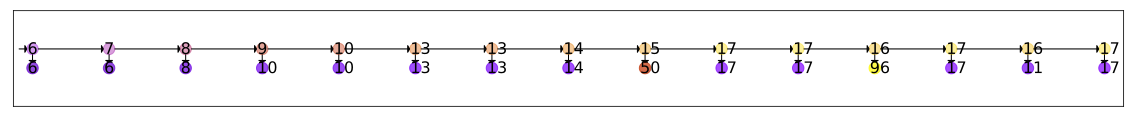

[ 0.  4.  8. 12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56.]


In [13]:
# sample a random sequence within desired time peroiod from the above created model(for testing and generation)

# sample length (seconds)
sample_len = 60

# sample step (s)
sample_step = 4

# sample uniformly
t_seq = range(0,sample_len, sample_step)
t_seq, s_seq, e_seq = chmm.generate( len(t_seq), time=t_seq)

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )
print(t_seq)

[0 1 2 3 4 5] [ 6  7  8 96]


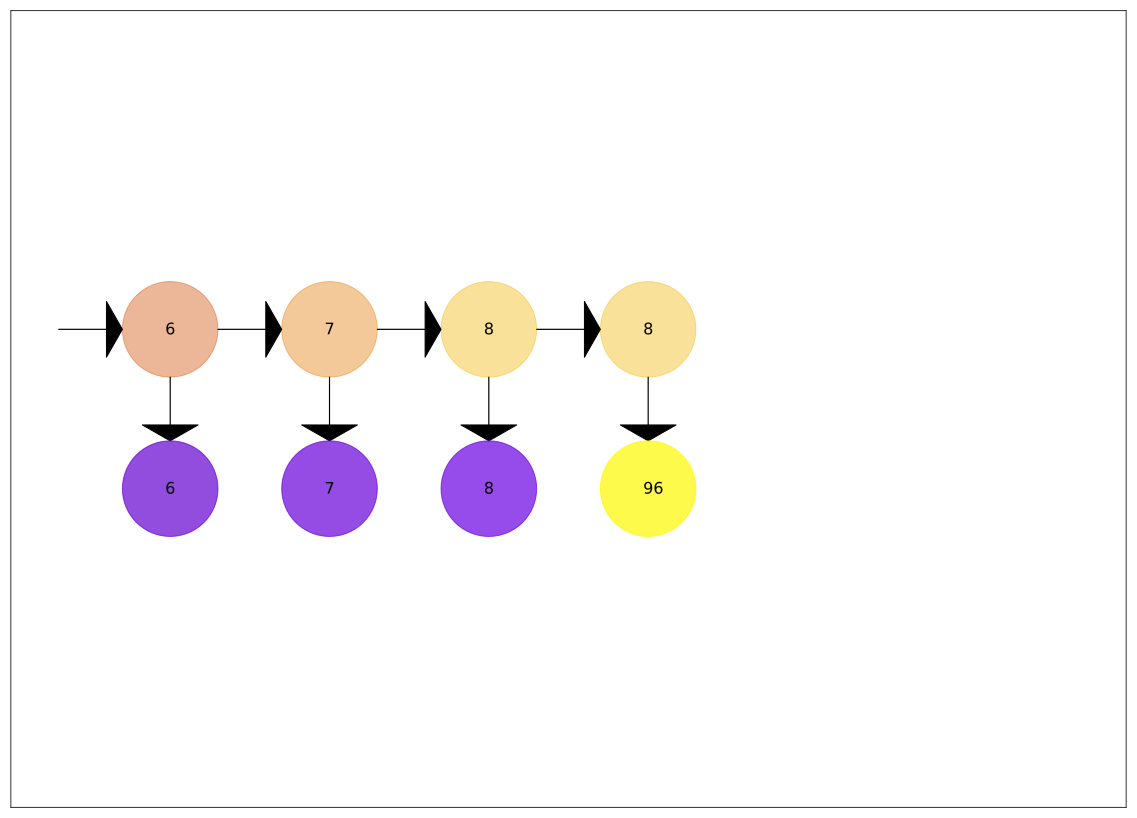

found state sequence: 
 [6 7 8 8]
predicted state looking 1.200000 seconds into the future: 8
Probability of being generated by the found state sequence: 5.215252749383567e-06
state probs: 
 [3.31001228e-08 3.31022202e-08 3.33127506e-08 5.24090726e-08
 1.61870285e-06 1.19485569e-04 7.88016720e-03 3.33173058e-01
 5.38290419e-01 1.08338151e-01 1.13507874e-02 7.99233826e-04
 4.23228931e-05 1.82512642e-06 9.65064426e-08 3.50321327e-08
 3.31521242e-08 3.31013722e-08 3.31001324e-08 3.31001042e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 3.31001036e-08 3.31001036e-08 3.31001036e-08
 3.31001036e-08 

In [24]:
# now let's try some prediction, define the predict function
# we will take n observation states 
def predict(obs=np.array([6, 7, 8, 9]), predict_time=20.0, verbose=False):

    # observations so far (this is where we have seen people being in a place at a specific time):
    e_seq = np.array(obs)
    # assume the observations were made 1 second apart
    t_seq = np.array(range(0,len(e_seq)+2))

    # Now the predict step 
    # the last observation codes for unknown,"abusing" the Viterbi algorithm to provide predictions 
    # purely on the transition model
    e_seq[-1:]=N_nodes 

    # this is the look ahead time (i.e. the time we look into the future based on the last observation)
    predict_time = 1.2

    # set the last "unknown" observation time:
    t_seq[-1] = t_seq[-2] + predict_time

    print(t_seq, e_seq)

    # run Viterbi algorithm for the CtHMM
    (log_prob, s_seq) =  chmm.viterbi( t_seq, e_seq )

    # We can also query the state distribution for the entire sequence
    log_prob_table = chmm.states_confidence( t_seq, e_seq )
    post_distribution = np.exp( log_prob_table[-1] )

    if verbose:
        # Let's print the most likely state sequence
        hmms.plot_hmm( s_seq, e_seq, time = t_seq )
        print( "found state sequence: \n", s_seq )
        print( "predicted state looking %f seconds into the future: %d" % (predict_time, s_seq[-1]) )
        print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )
        print( "state probs: \n", post_distribution)

    uniform = np.array([1.0 / N_nodes] * N_nodes)   # get the 1 X N_nodes matrix of uniform distribution

    # Now KL divergence is used to get the difference between the two distributions-- 
    # (here btween uniform and post_distribution) and is denoted by D_KL = (post_distribution || uniform) = 
    # itergral of (p(x)* log((px)/q(x))
    # KL divergence: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Basic_example
    # KL can be used here as a measure of certainty to some extend, used to compare against uniform distribution,
    # the longer into the future the prediction, the closer KL is to 0
    D_KL = np.sum(np.multiply(post_distribution, np.log(np.divide(post_distribution, uniform))))
    if verbose:
        print("Kullback–Leibler divergence (high is good in this case, as I compare against uniform): %f" % D_KL)

    return (s_seq[-1], D_KL, post_distribution)
    
    #for i in range(0,len(uniform)):


(state, KL, posteriors) = predict(
# start with some observations assumed to have made up to a point
obs=np.array([6,7,8, 9]),
# the time horizon to predict to
predict_time=20,
# we want to see stuff here
verbose=True
)

[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] [ 6  7  8 96]
[0 1 2 3 4] 

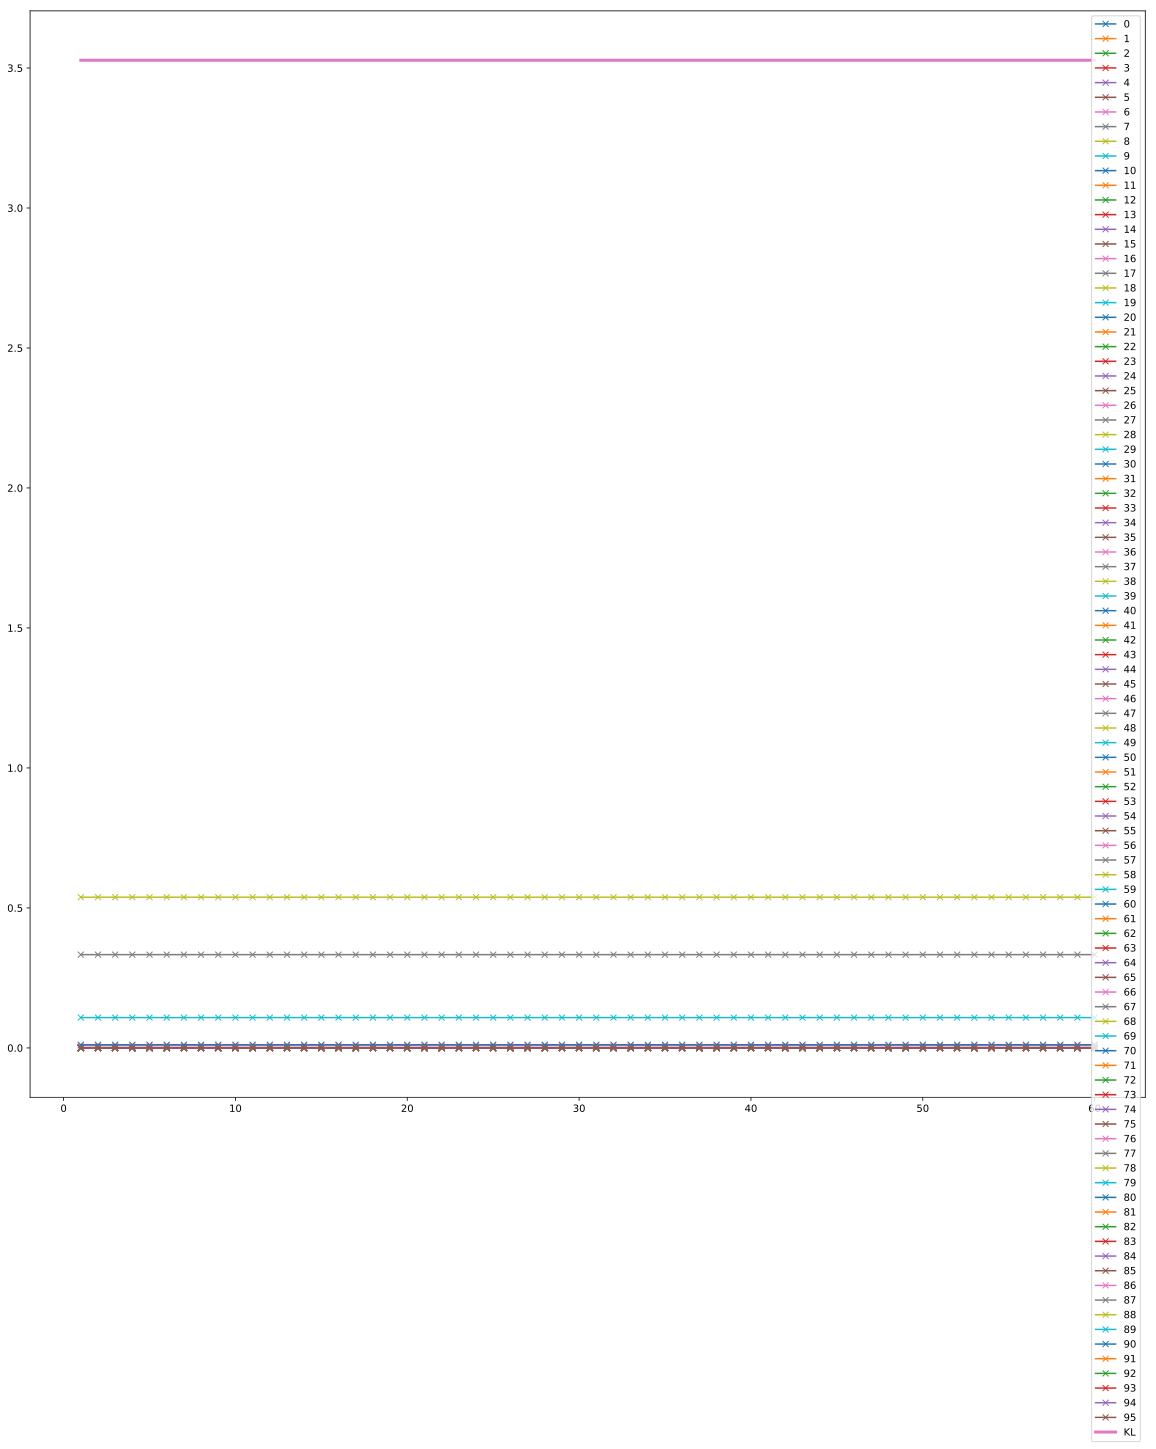

In [22]:
# now some iterations:

# forecast max seconds
forecast_max = 60
forecast_steps = 60


posteriors = []
states = {}
kls = []
times = []
bars = []

# try forecasting for several time steps:
for i in np.linspace(1, forecast_max, forecast_steps):  # Return evenly spaced numbers over a specified interval (start,stop, Num = int).
    (state, kl, posterior) = predict(
        obs = [6,7,8,9],
        predict_time = i,
        verbose = False
    )
    times.append(i)
    posteriors.append(posterior)
    states[i] = state
    kls.append(kl)

# plot the posterior probabilities
plt.plot(times, posteriors, '-x')

# plot the KL divergence (certainty)
plt.plot(times, kls, linewidth=3)

legend = list(range(0, N_nodes))
legend.append('KL')
plt.legend(legend)
print('state predictions:\n%s' % pformat(states))